GJ 674 has contiumn?

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from matplotlib.gridspec import GridSpec


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [14]:
path = '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/GJ674/'
hlsp = glob.glob('{}*.fits'.format(path))
hlsp

['/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/GJ674/hlsp_muscles_hst_cos_gj674_g130m_v124_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/GJ674/hlsp_muscles_hst_stis_gj674_g140l_v24_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/GJ674/hlsp_muscles_hst_stis_gj674_g140m_v24_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/GJ674/hlsp_muscles_hst_stis_gj674_g230l_v24_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/GJ674/hlsp_muscles_hst_stis_gj674_g430l_v24_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/GJ674/hlsp_muscles_model_apec_gj674_na_v24_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/GJ674/hlsp_muscles_model_dem_gj674_na_v24_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/GJ674/hlsp_muscles_model_euv-scaling_gj674_na_v24_component-spec.fits',
 '/media/david/2tb_ext_hd/hdd

In [6]:
sed = fits.getdata('{}hlsp_muscles_multi_multi_gj674_broadband_v24_var-res-sed.fits'.format(path),1)
wsed, fsed, esed = sed['WAVELENGTH'], sed['FLUX'], sed['ERROR']

Quesent COS spectrum

In [13]:
qw, qf, qe = np.loadtxt('/media/david/2tb_ext_hd/hddata/mega_muscles/gj674_flare/GJ674_mega_G130M_Quiesc.sav.txt', unpack=True, skiprows = 1)

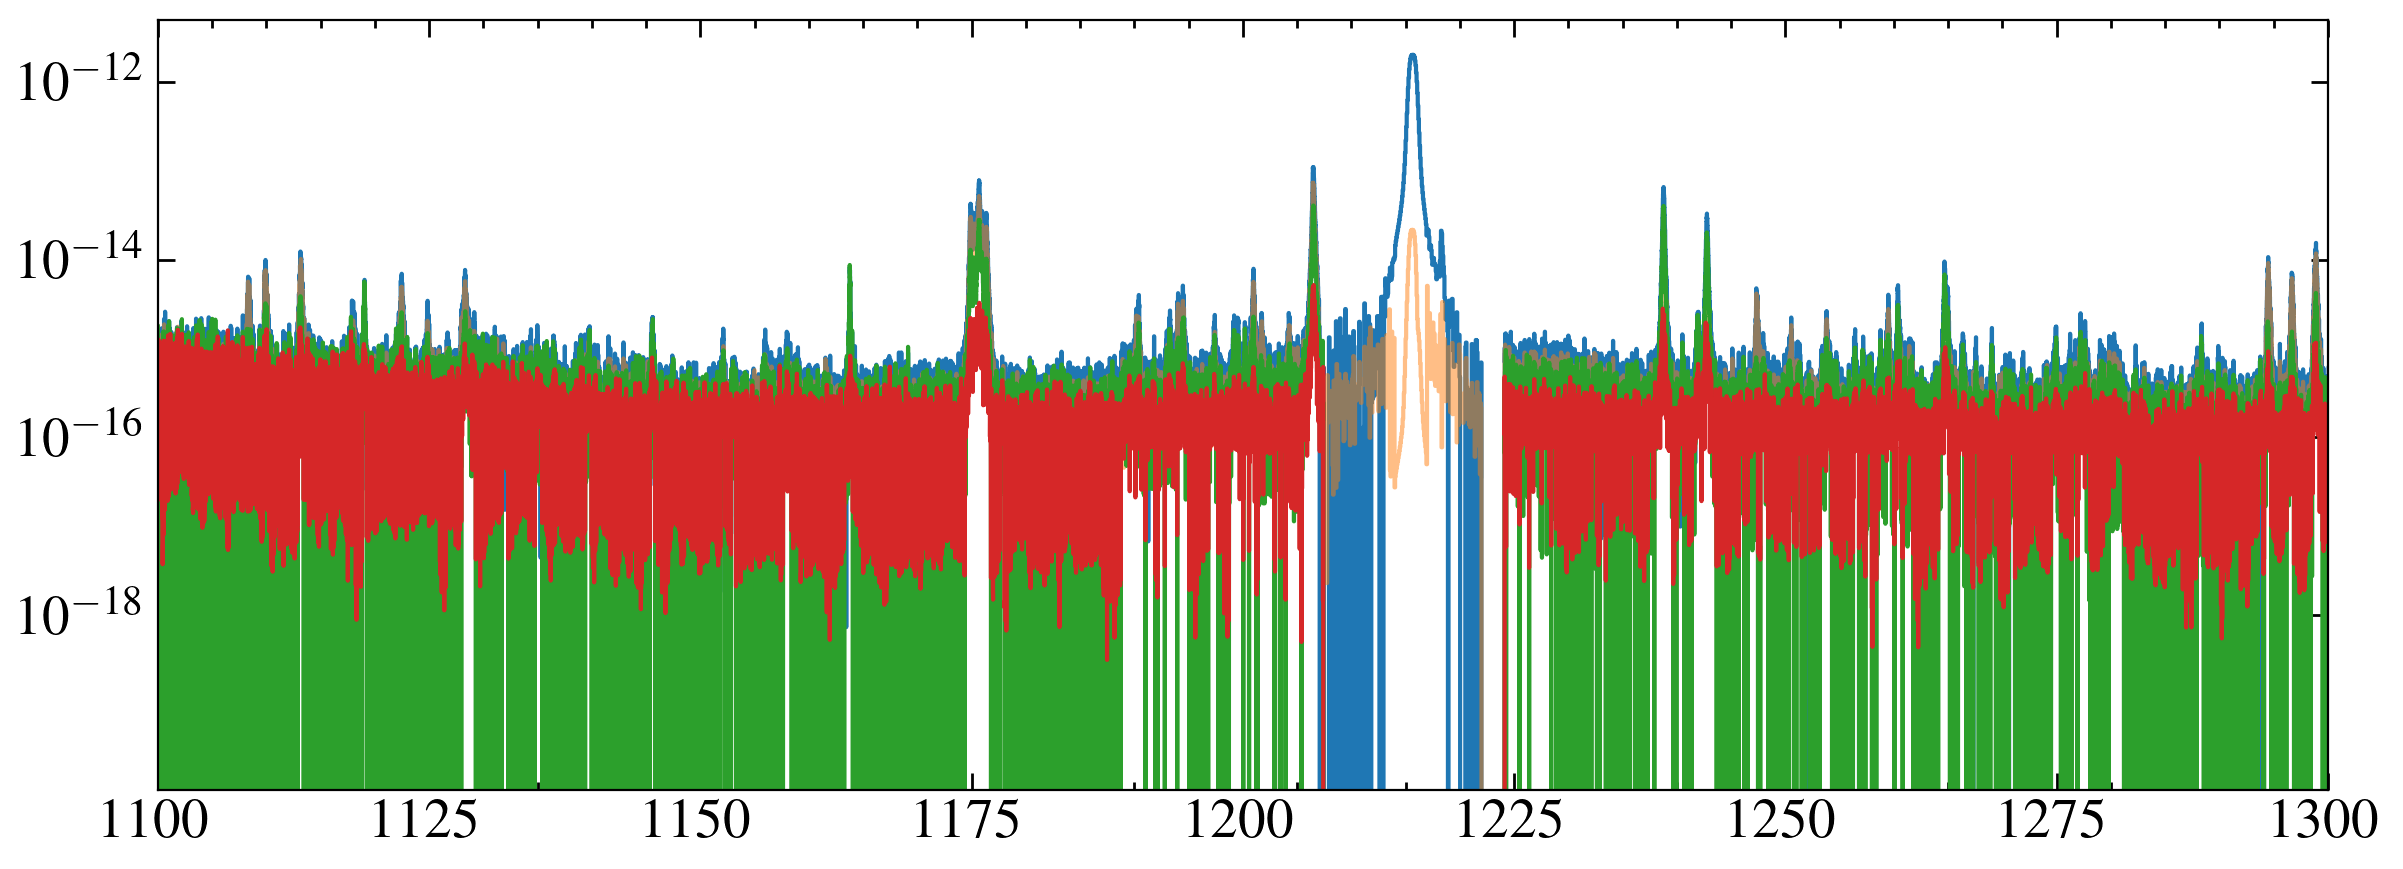

In [16]:
fig, ax = plt.subplots()

mask =( wsed > 1100 ) & (wsed < 3000)

ax.step(wsed[mask], fsed[mask], where='mid')
ax.step(wsed[mask], esed[mask], where='mid', alpha=0.5)

ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim(1100, 1300)

ax.step(qw, qf, where='mid')
ax.step(qw, qe, where='mid')

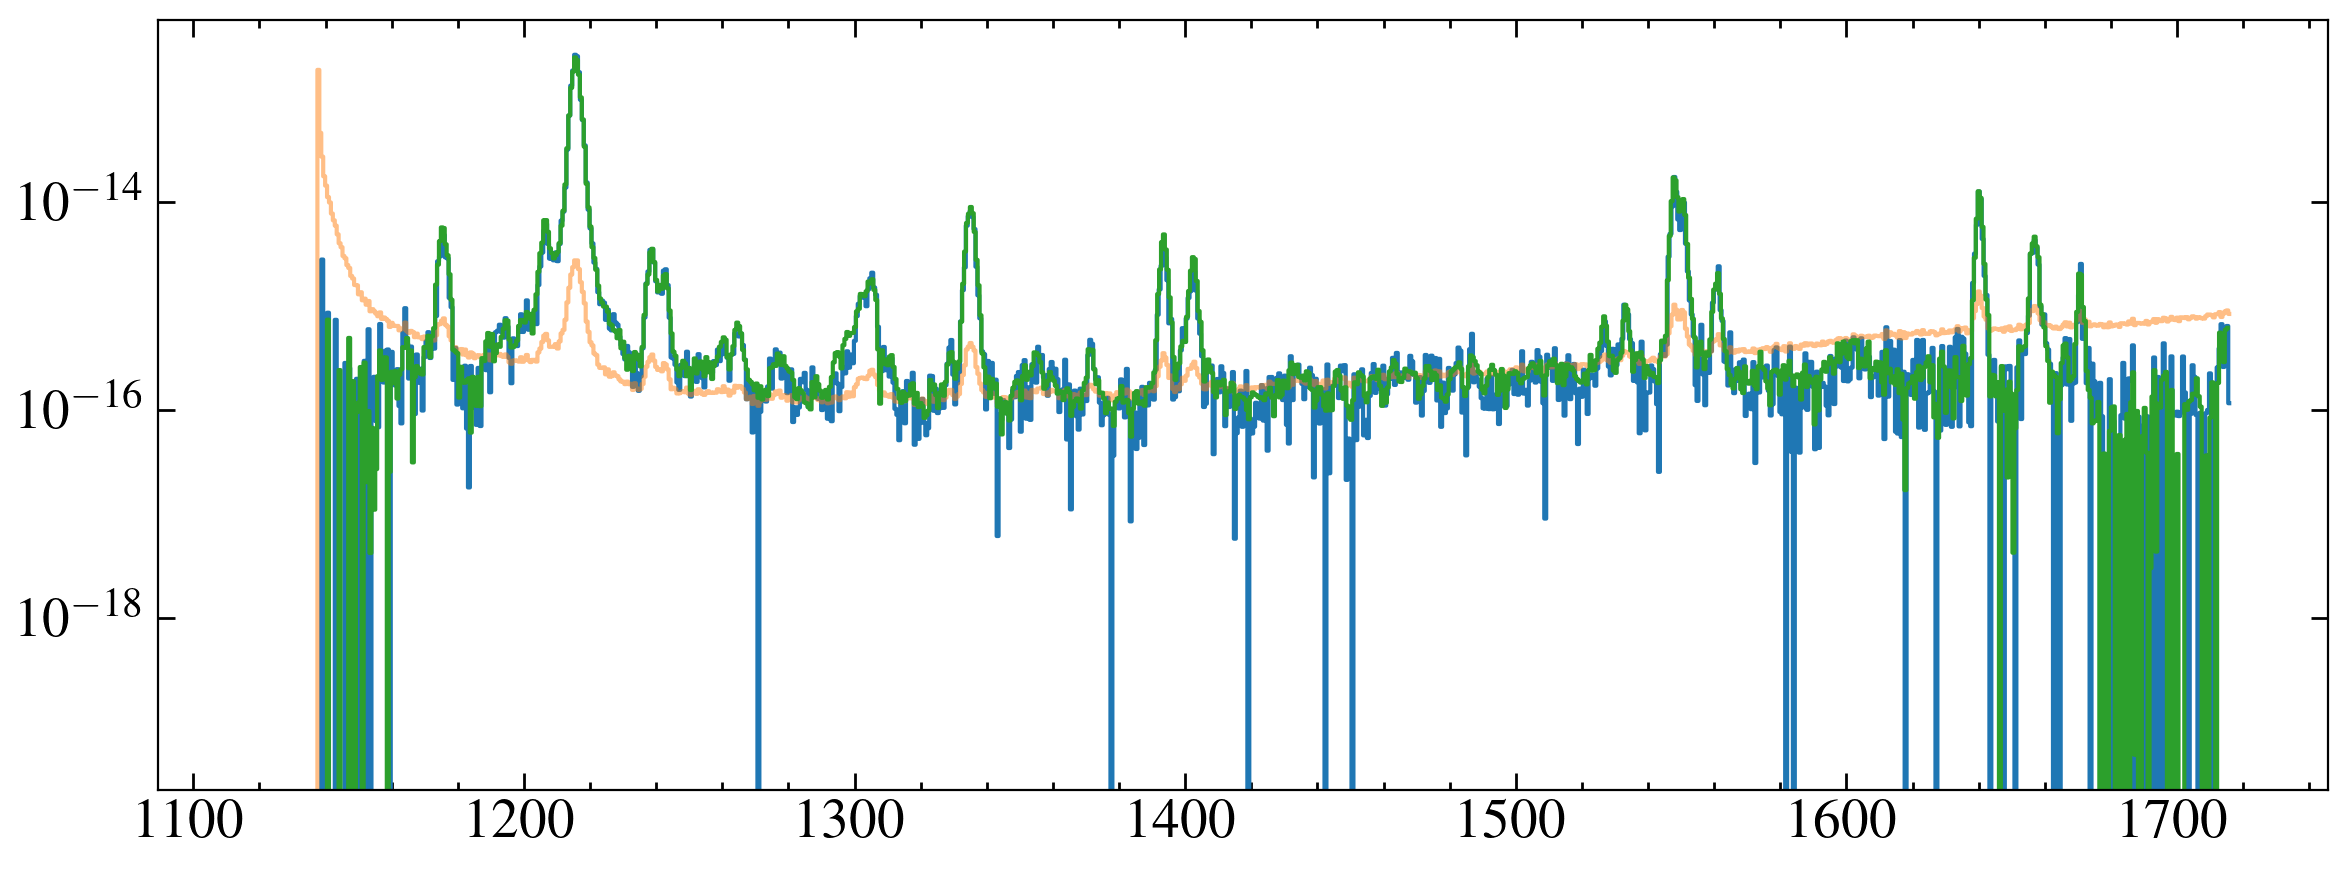

In [163]:
qs = fits.getdata('../gj_674/STIS/noflare_x1d.fits', 1)[0]
fig, ax = plt.subplots()

ax.step(qs['WAVELENGTH'], qs['FLUX'], where='mid')
ax.step(qs['WAVELENGTH'], qs['ERROR'], where='mid', alpha=0.5)

ax.set_yscale('log')

flare = fits.getdata(hlsp[1], 1)
ax.step(flare['WAVELENGTH'], flare['FLUX'], where='mid')

sw, sf, se = flare['WAVELENGTH'], flare['FLUX'], flare['ERROR']

(1160.0, 1747.6326968339235)

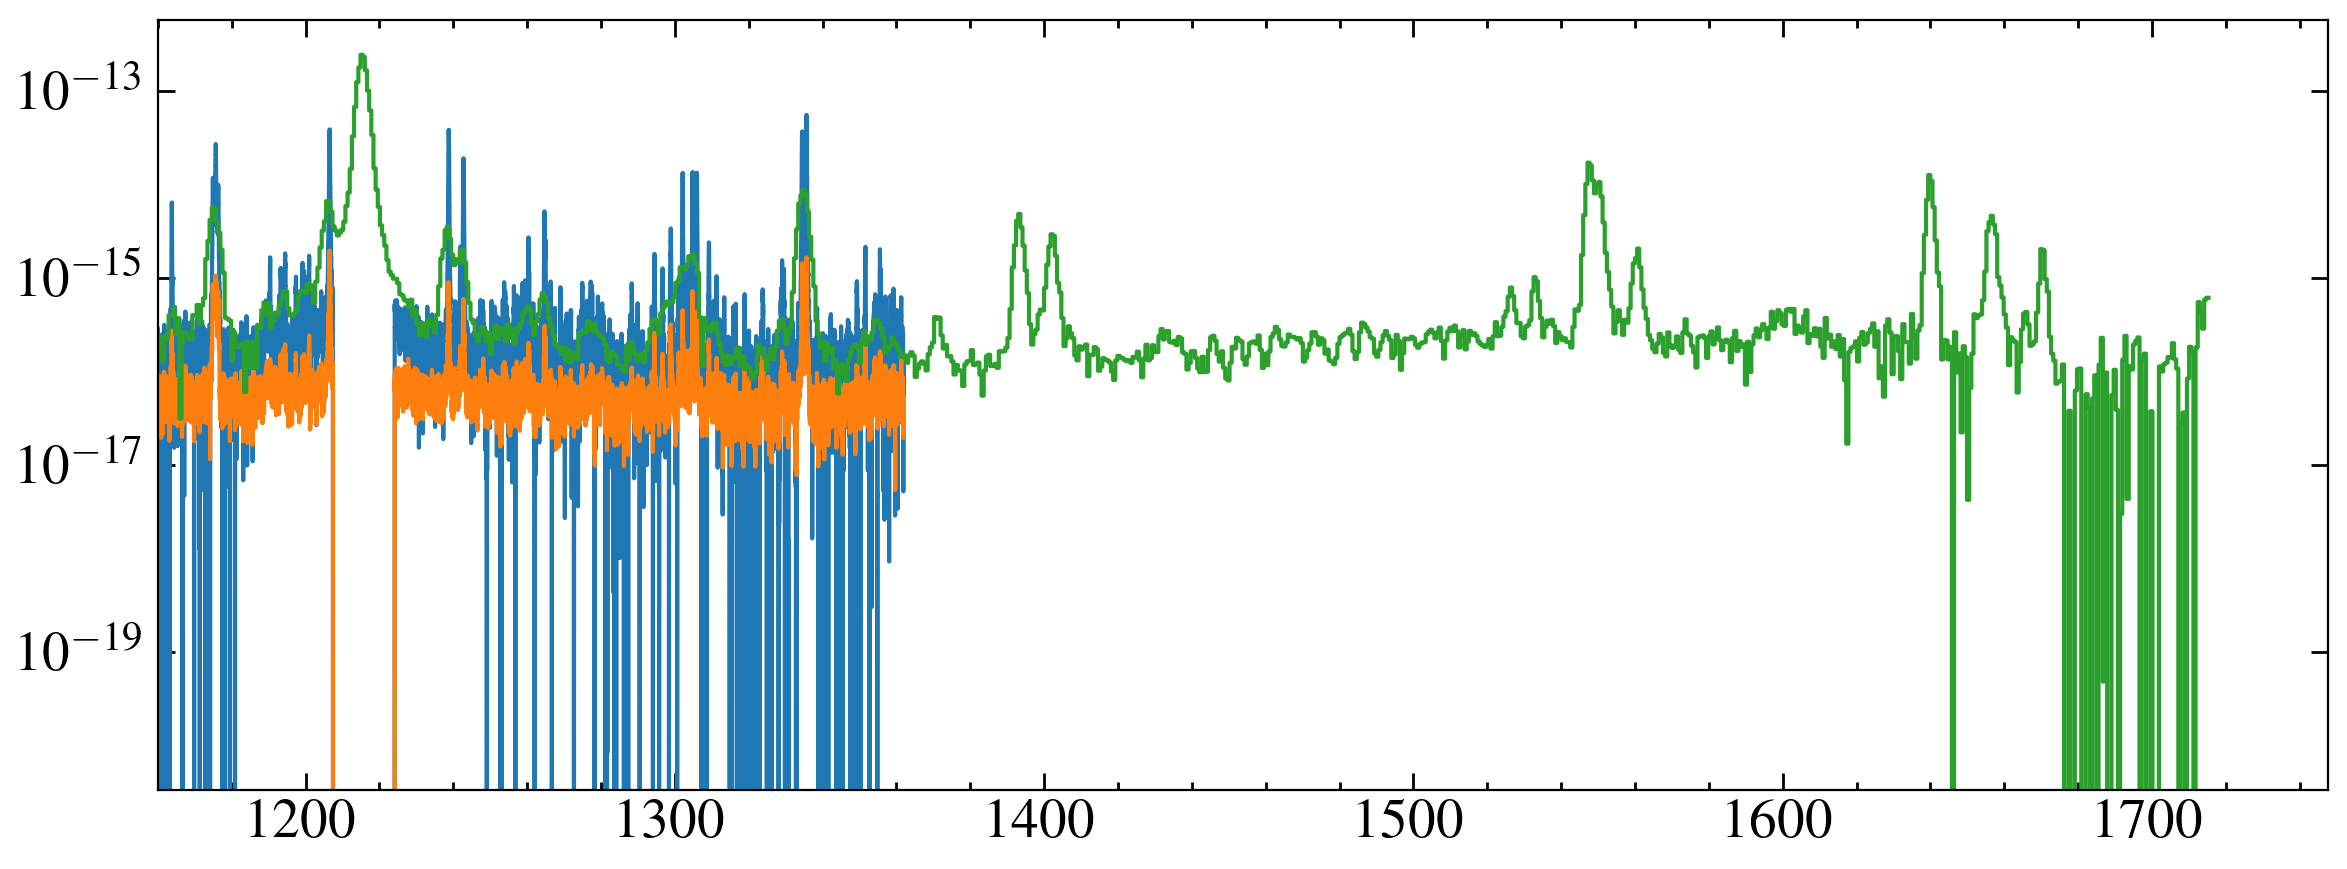

In [32]:
qfi = convolve(qf, Box1DKernel(5))
qei = convolve(qe, Box1DKernel(5))/(5**0.5)
 

fig, ax = plt.subplots()

ax.step(qw, qfi, where='mid')
ax.step(qw, qei, where='mid')

ax.set_yscale('log')

ax.step(sw, sf)

ax.set_xlim(1160)

/tmp/ipykernel_50489/3966430506.py:11: RuntimeWarning: invalid value encountered in divide
  ax.step(nw, nf/ne, where='mid')


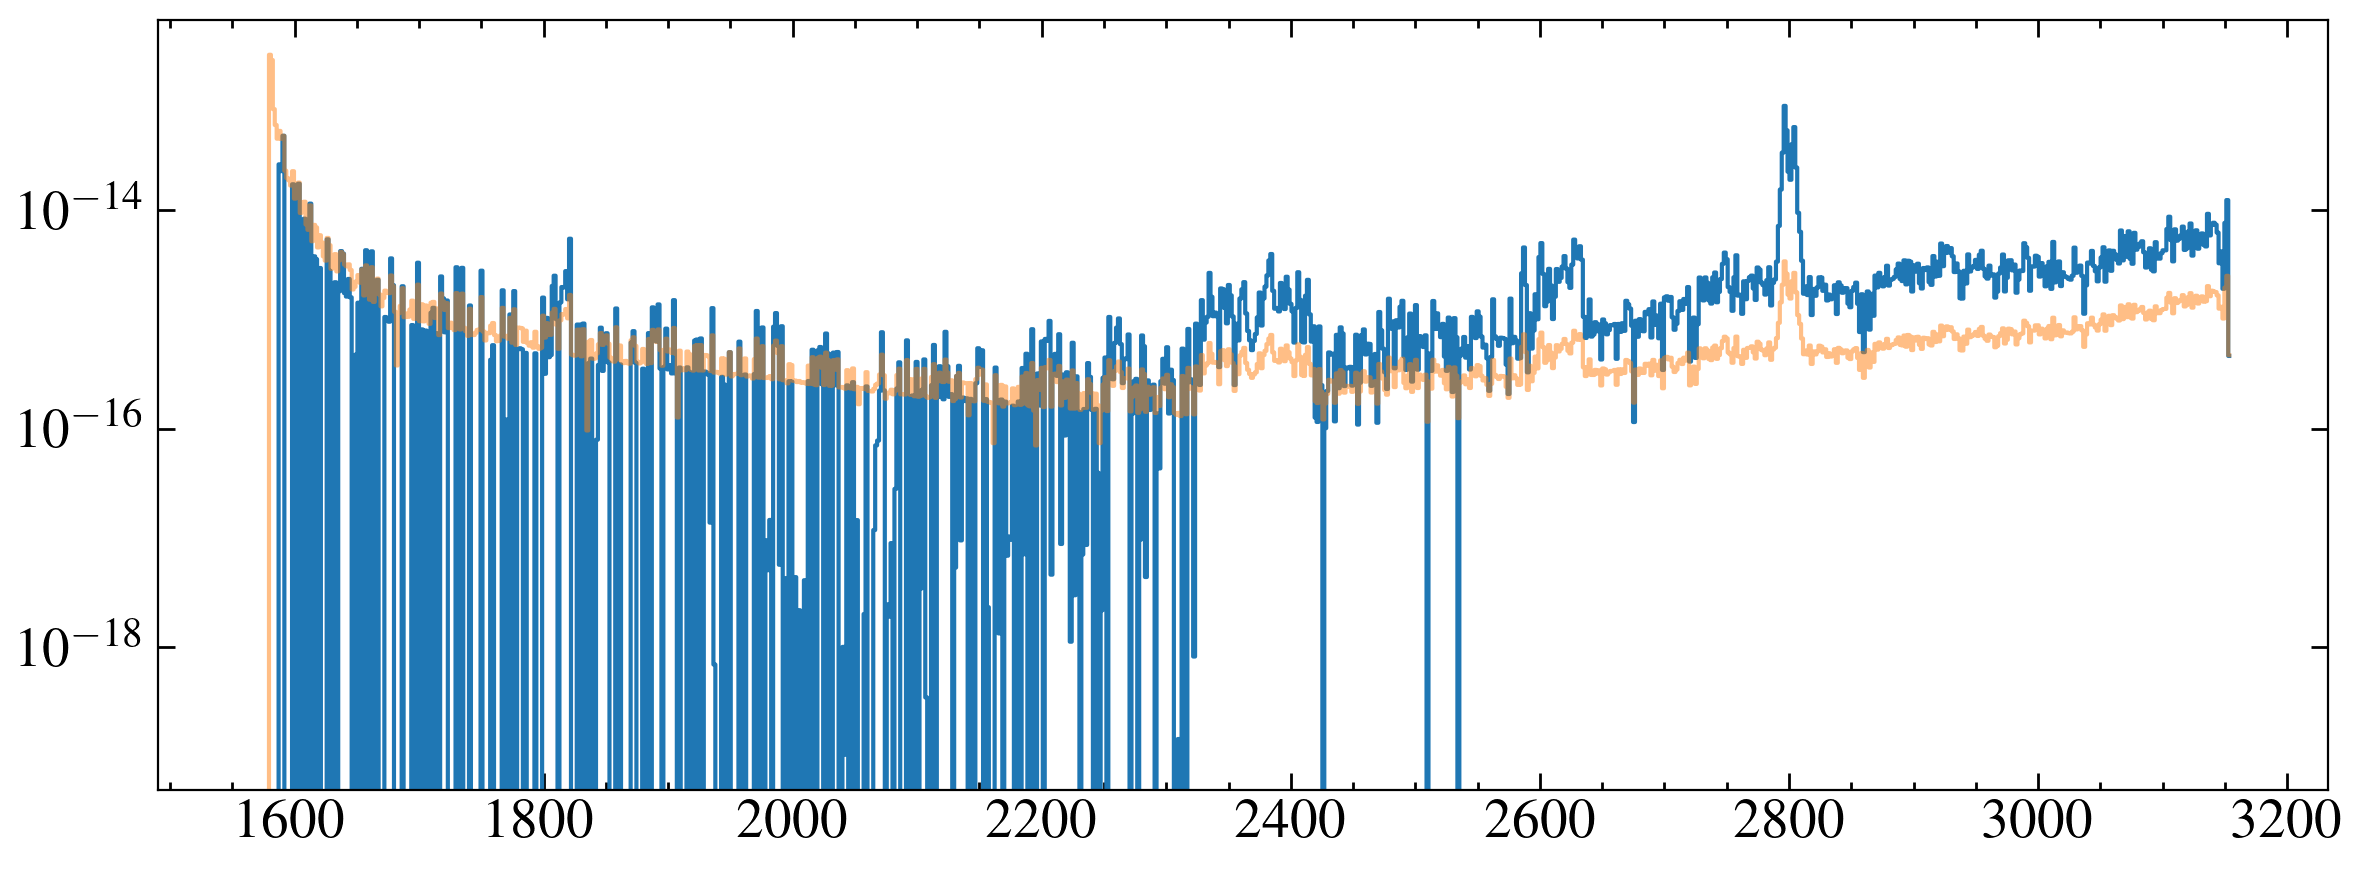

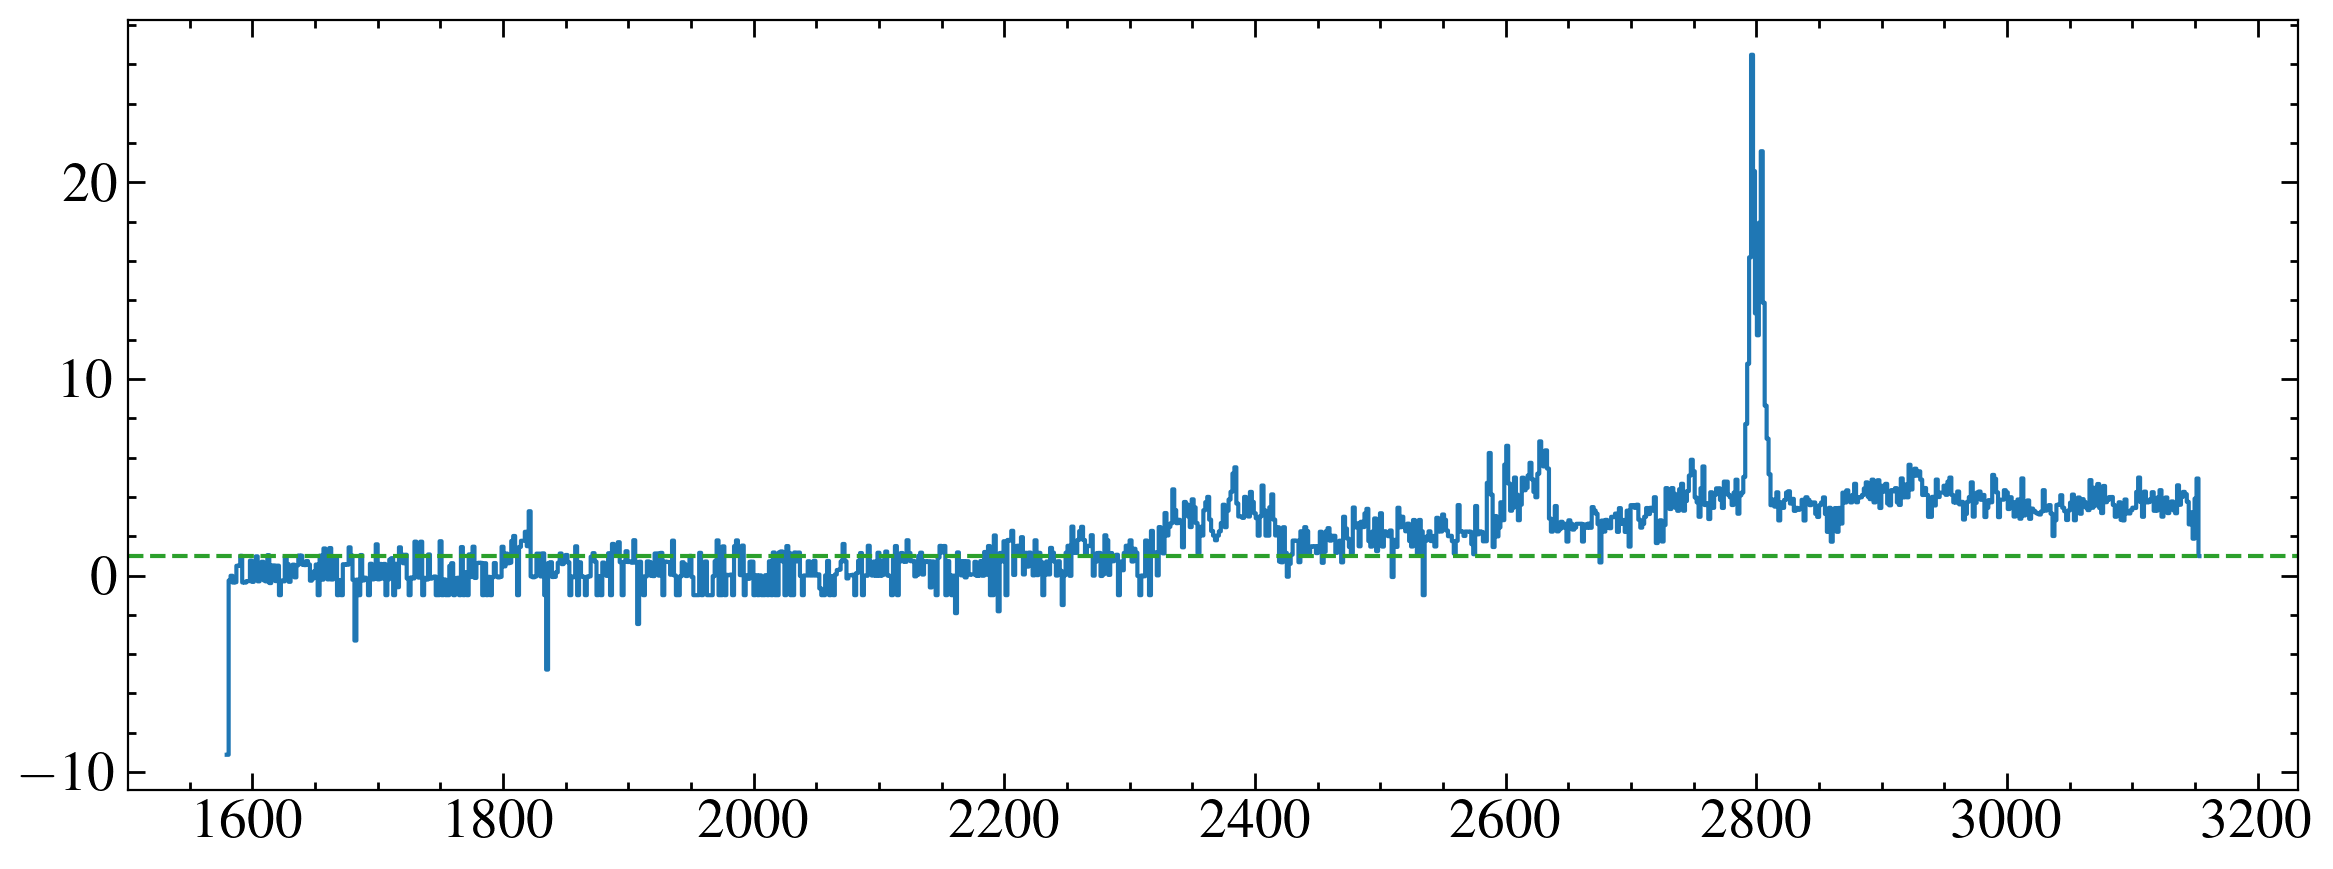

In [38]:
nspec = fits.getdata(hlsp[3])
nw, nf, ne = nspec['WAVELENGTH'], nspec['FLUX'], nspec['ERROR']
fig, ax = plt.subplots()

ax.step(nw, nf, where='mid')
ax.step(nw, ne, where='mid', alpha=0.5)

ax.set_yscale('log')

fig, ax = plt.subplots()
ax.step(nw, nf/ne, where='mid')
ax.axhline(1, ls='--', c='C2')


In [37]:
((10**14)*u.km).to(u.Rsun)

<Quantity 1.43740118e+08 solRad>

In [42]:
# swiftpath = '/media/david/2tb_ext_hd/hddata/mega_muscles/swift/gj674/'
# swift_ims = glob.glob('{}*/uvot/products/*sk.img*'.format(swiftpath))

# for im in swift_ims:
#     print(im)
#     print(fits.getheader(im, 1)['FILTER'])

Looks like 2300 A for the NUV spectrum. Use just the STIS FUV spectrum to avoid complications?

In [67]:
phx = fits.getdata(hlsp[9], 1)
pwi, pfi = phx['WAVELENGTH'], phx['FLUX']*fits.getheader(hlsp[9], 0)['NORMFAC']

In [72]:
pwmask = (pwi > 1000) & (pwi < 3500) 

pw, pf = pwi[pwmask], pfi[pwmask]

respix = (pw[-1] - pw[0])/len(pw)
# print(respix)
FWHM = 1.6/respix #for 3A res
sigma = FWHM / (2 * np.sqrt(2 * np.log(2)))


pf = convolve(pf, Gaussian1DKernel(sigma))

In [126]:
eps_eri = fits.getdata('/media/david/2tb_ext_hd/hddata/mega_muscles/muscles_hlsp/v-eps-eri/hlsp_muscles_multi_multi_v-eps-eri_broadband_v22_var-res-sed.fits', 1)

ew, ef = eps_eri['WAVELENGTH'], eps_eri['FLUX']

In [164]:
soldat = Table.read('../../../hwo/Solar_1au_sed.csv')
solw, solf = soldat['WAVELENGTH'], soldat['FLUX']

(5.1e-17, 5.9e-16)

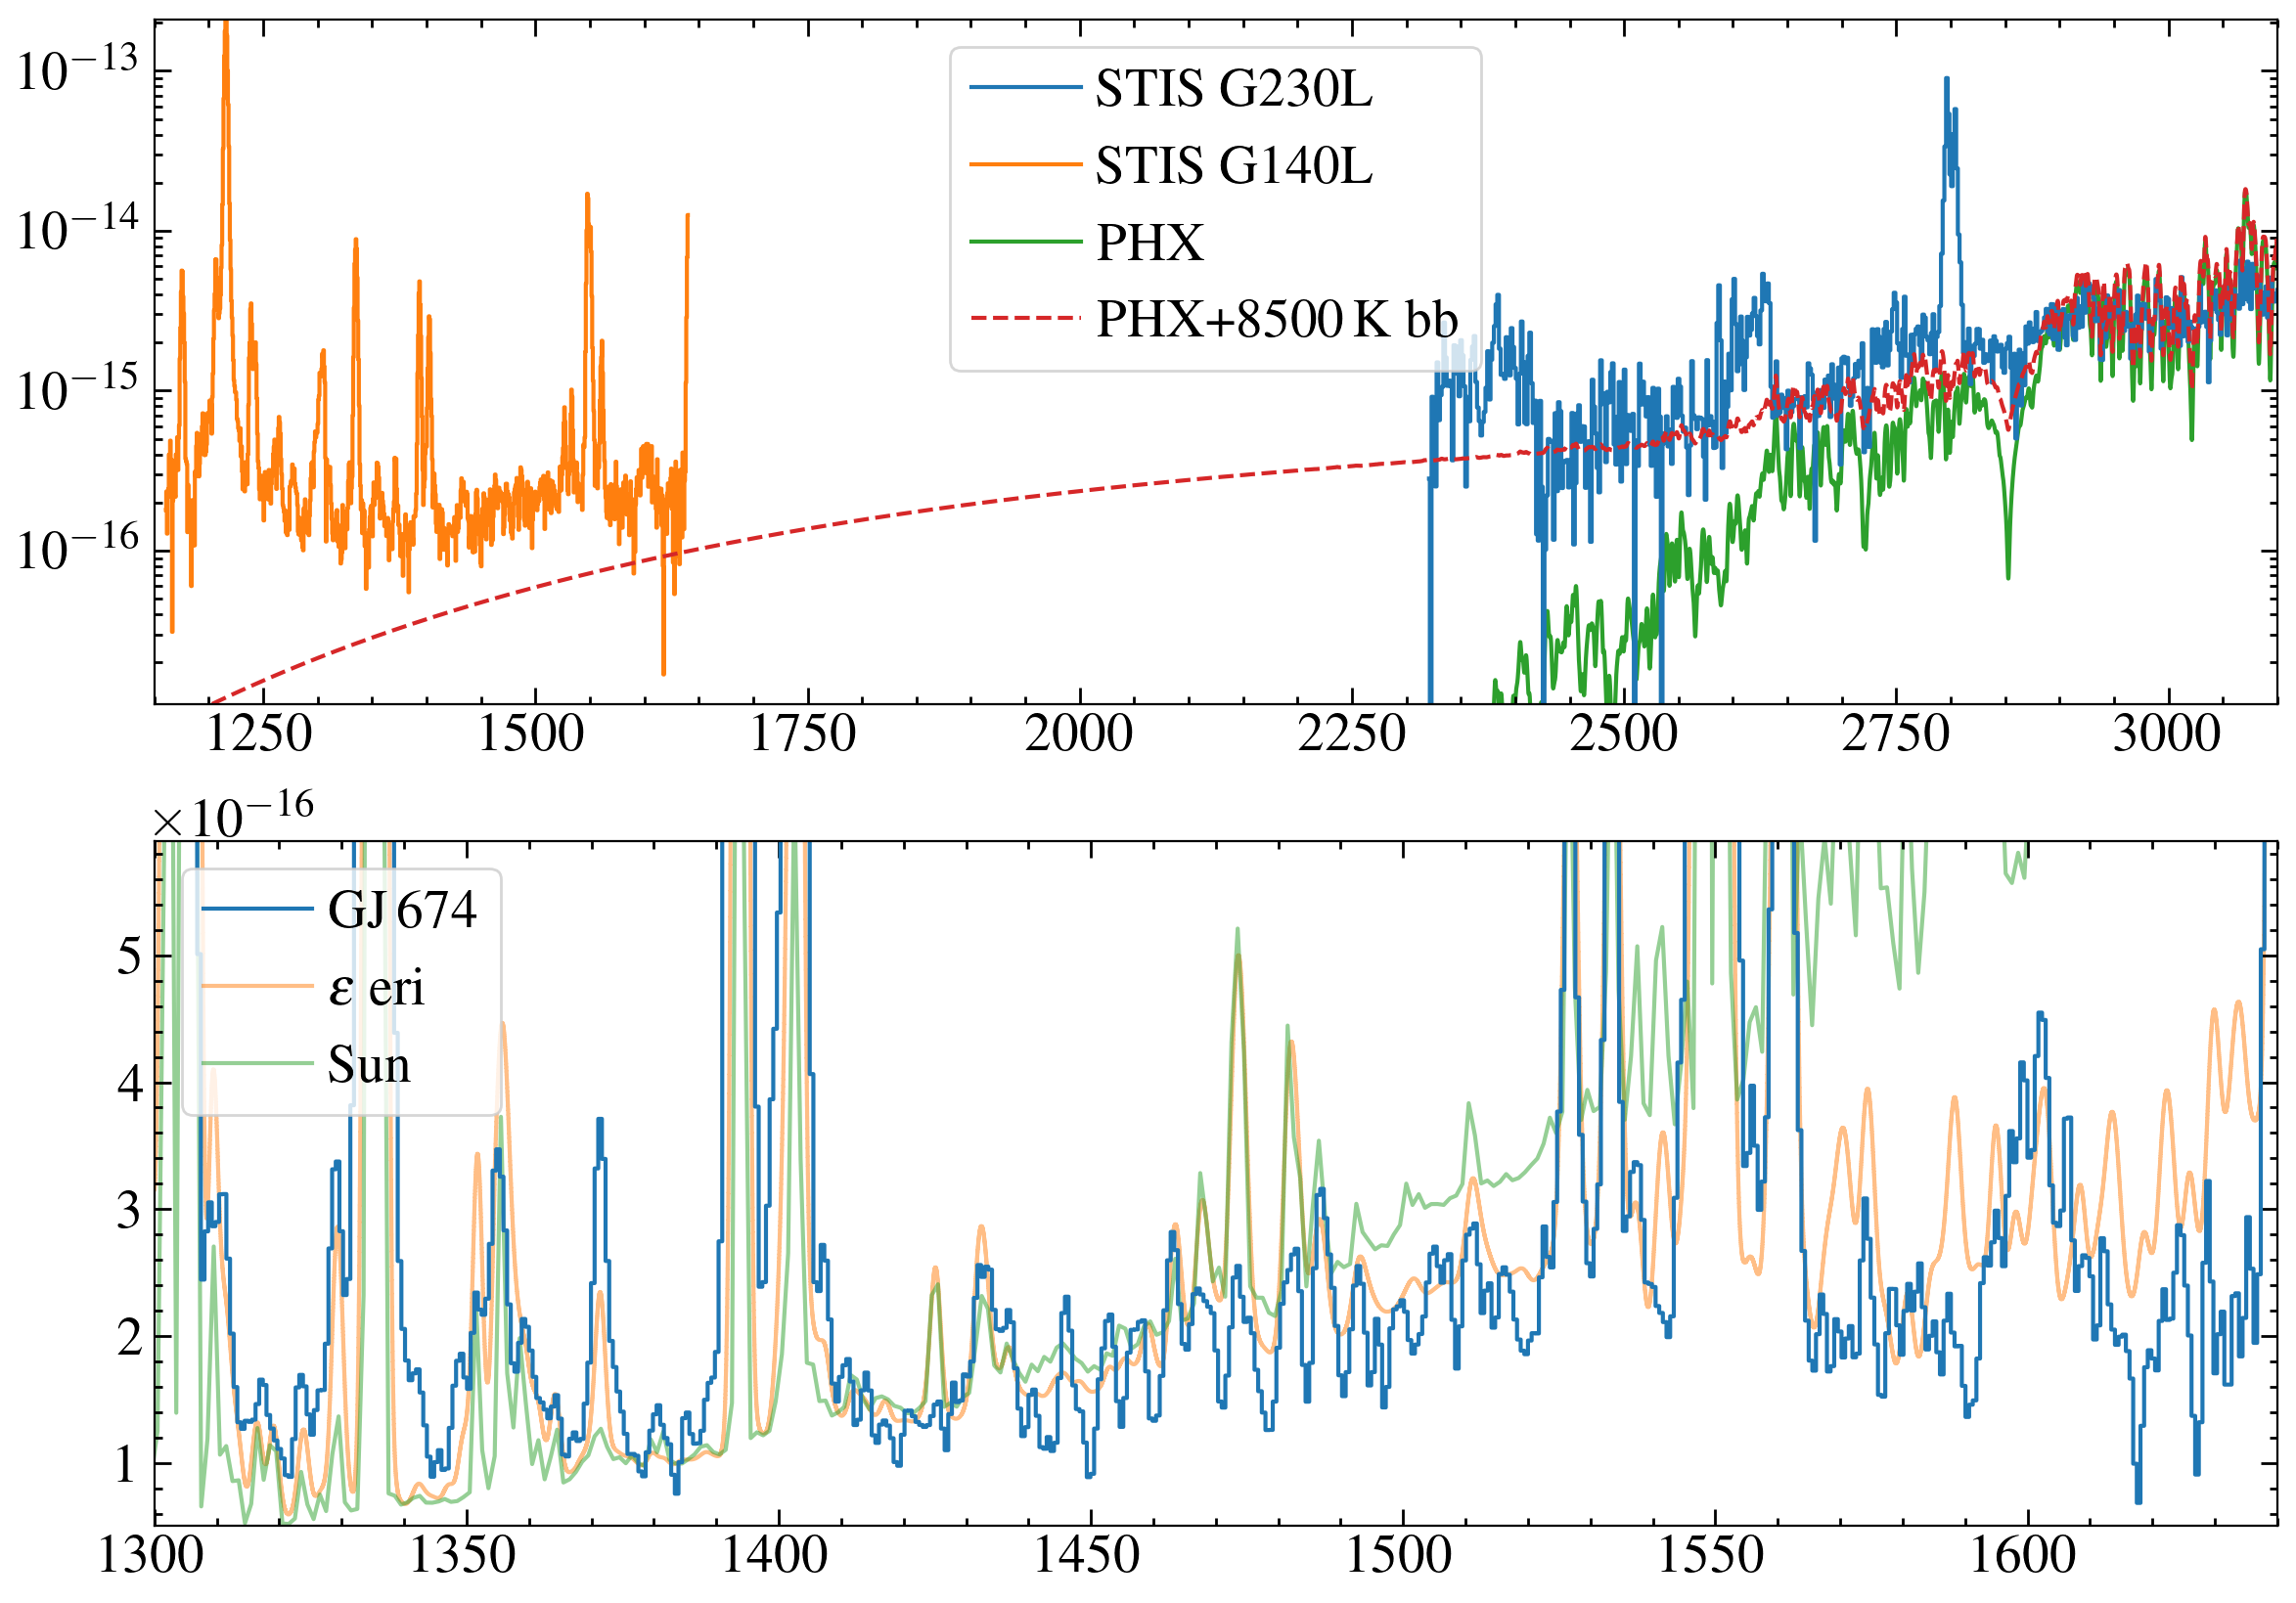

In [177]:
nmask = (nw > 2320)
smask = (sw > 1160) & (sw < 1640)

fig, axes = plt.subplots(figsize=(14, 10), nrows=2)

ax = axes[0]

ax.step(nw[nmask], nf[nmask], where='mid', label='STIS G230L')
ax.step(sw[smask], sf[smask], where='mid', label='STIS G140L')
# ax.step(sw, sf)

ax.plot(pw, pf, zorder=-1, label = 'PHX')

pfs = interp1d(pw, pf, fill_value='extrapolate')(nw)

# ax.step(nw[nmask], nf[nmask]-pfs[nmask], where='mid')


bb_mod = models.BlackBody(temperature=8500*u.K, scale=3e-23*u.erg/u.s/u.cm**2/u.AA/u.sr, fixed=dict(temperature=True))
# modw = np.linspace(1000, 3200, 1000)

# ax.plot(pw, bb_mod(pw), ls='--')
ax.plot(pw, bb_mod(pw).value+pf, ls='--', label='PHX+8500\,K bb')
ax.legend(frameon=True)


ax.set_yscale('log')
ax.set_ylim(1.1e-17, 2.1e-13)
ax.set_xlim(1150, 3100)
# ax.se


emask = (ew > 1000) & (ew < 2000)
sfi = convolve(sf, Box1DKernel(2))

axes[1].step(sw[smask], sfi[smask], where='mid', label='GJ\,674')
# axes[1].errorbar(sw[smask], sf[smask], yerr=se[smask], errorevery=10, drawstyle='steps-mid', label='GJ\,674')
# sei = convolve(se, Box1DKernel())
# axes[1].step(sw[smask], sei[smask], where='mid', alpha=0.5)


efi = convolve(ef, Gaussian1DKernel(80))
axes[1].step(ew[emask], efi[emask]*0.03, where='mid', label=r'$\epsilon$ eri', zorder=-1, alpha=0.5)

solmask = (solw > 1000) & (solf < 2000)

axes[1].plot(solw[solmask], solf[solmask]*4e-14, zorder=-1, alpha=0.5, label='Sun')

axes[1].legend(frameon=True)
axes[1].set_xlim(1300, 1640)
axes[1].set_ylim(0.51e-16, 0.59e-15)


Look at TESS data

In [105]:
# import lightkurve as lk


In [106]:
# search_result = lk.search_lightcurve('GJ 674')
# search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 12,2019,SPOC,120,218263393,0.0
1,TESS Sector 39,2021,SPOC,20,218263393,0.0
2,TESS Sector 39,2021,SPOC,120,218263393,0.0
3,TESS Sector 66,2023,SPOC,20,218263393,0.0
4,TESS Sector 66,2023,SPOC,120,218263393,0.0
5,TESS Sector 12,2019,TESS-SPOC,1800,218263393,0.0
6,TESS Sector 39,2021,TESS-SPOC,600,218263393,0.0
7,TESS Sector 66,2023,TESS-SPOC,200,218263393,0.0
8,TESS Sector 12,2019,QLP,1800,218263393,0.0


0
2
4
[0, 2, 4]


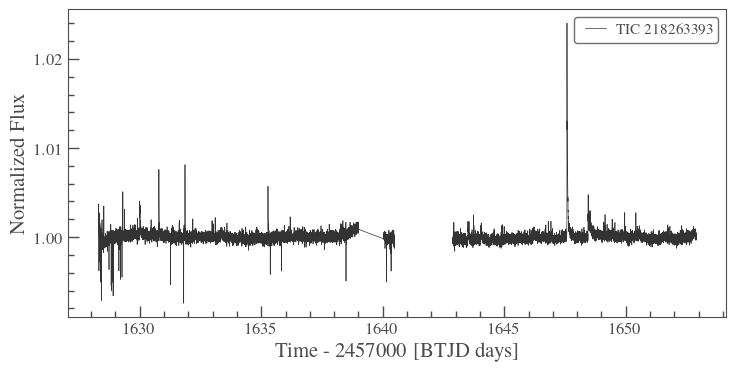

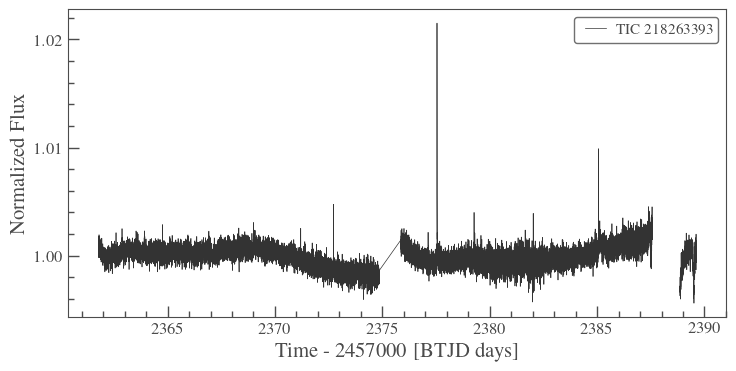

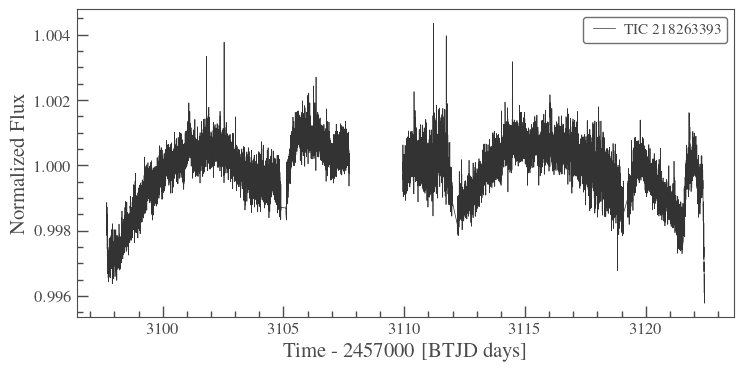

In [109]:
# lc120s = []
# for i, sr in enumerate(search_result):
#     if sr.exptime[0].value == 120 and sr.author[0] == 'SPOC':
#         print(i)
#         lc120s.append(i)
# #         print(sr./#[0])
#         lc = sr.download(download_dir='mastDownload/')
#         lc = lc.normalize()
#         lc.plot()
# print(lc120s)